In [186]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import math
import datetime as dt
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score


In [187]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/HPG-Historical-Data.csv')
df = df[['Close']]

In [188]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập validation
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# Lấy các giá trị đóng cửa của tập huấn luyện
train_close_prices = train_data['Close'].values

# Chuẩn hóa dữ liệu về phạm vi từ 0 đến 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_prices = scaler.fit_transform(train_close_prices.reshape(-1, 1)).flatten()



In [189]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def stationarity(col):
    res = adfuller(col.dropna())
    print("Test Statistic:", res[0])
    print("P-Value:", res[1])
    if res[1] < 0.05:
        print("Stationary")
    else:
        print("Non-Stationary")

Test Statistic: -1.3599010096956987
P-Value: 0.6013420650152539
Non-Stationary


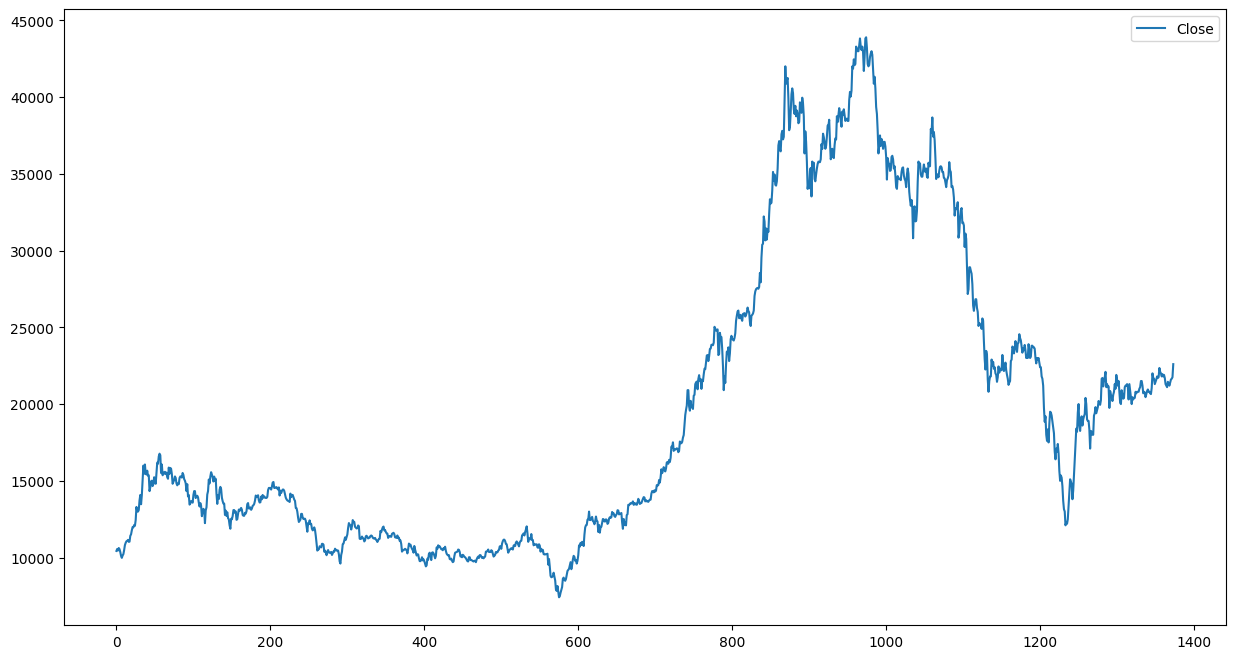

In [190]:
df.plot(figsize=(15,8))

stationarity(df)

Test Statistic: -7.78675253364445
P-Value: 8.141223392312719e-12
Stationary


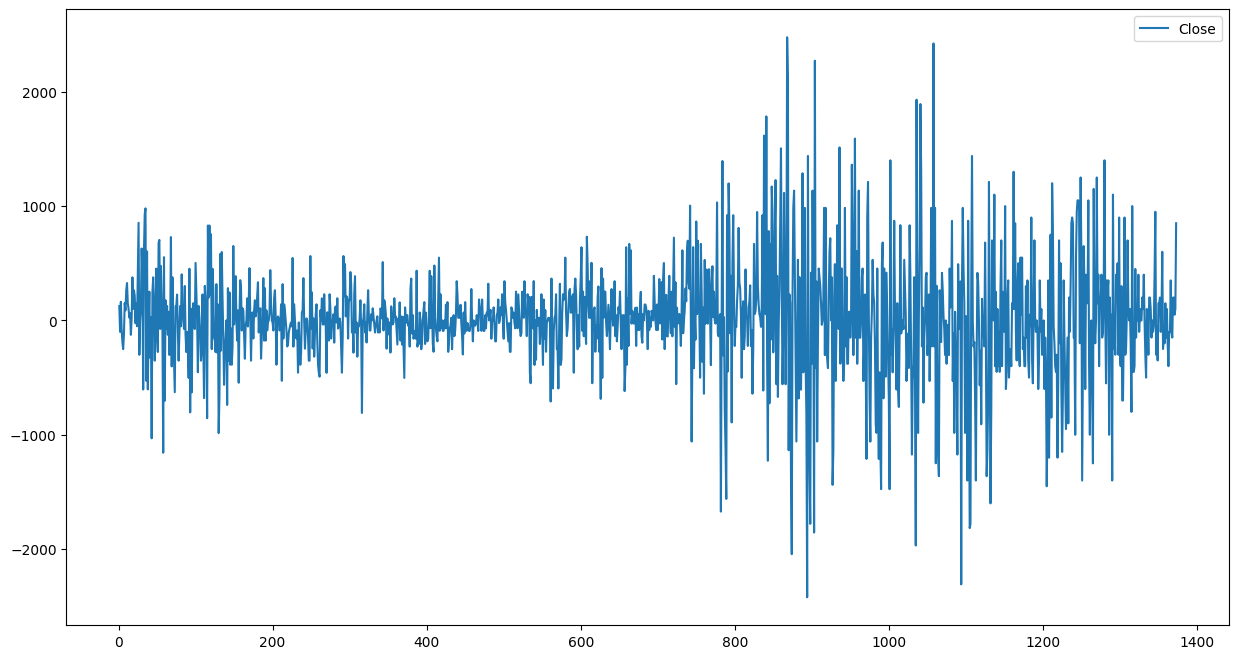

In [191]:
df= df.diff().dropna()
df.plot(figsize=(15,8))

stationarity(df)

In [192]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

def pacf(col):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(col)
    ax1.set_title('The Column Diff')
    plot_pacf(col, method='ywm', ax=ax2);


def acf(col):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(col)
    ax1.set_title('The Column Diff')
    plot_acf(col, ax=ax2);

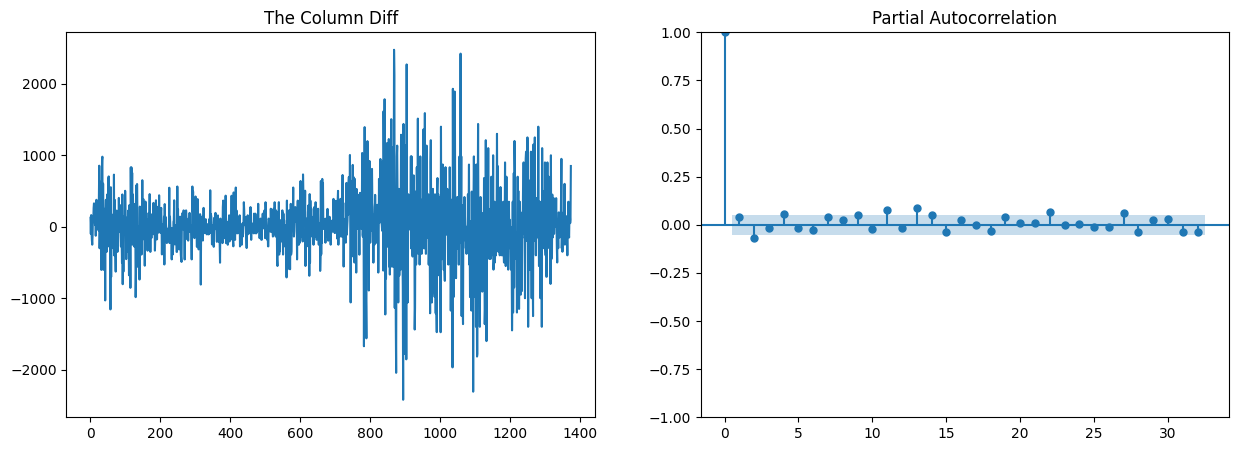

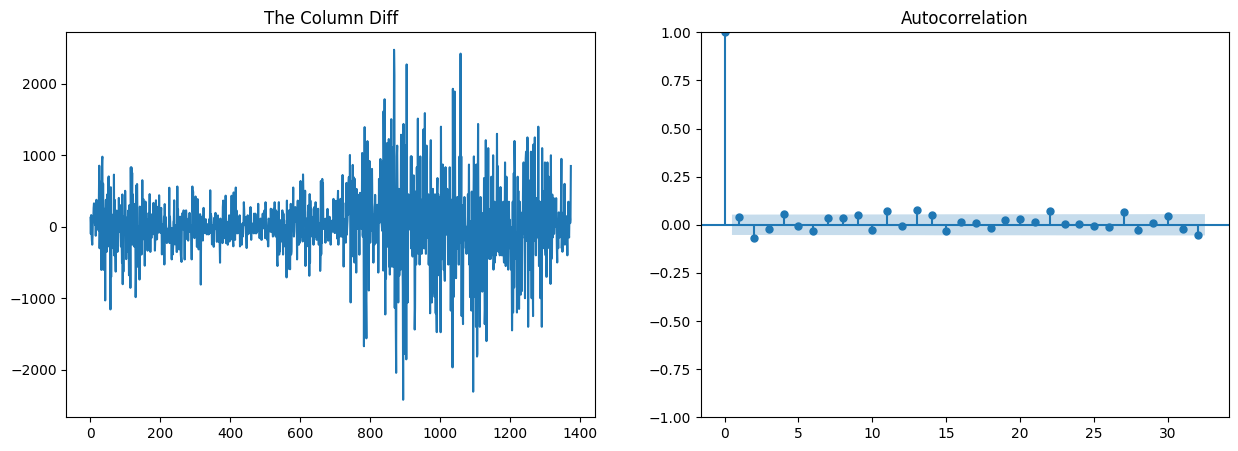

In [193]:
pacf(df)
acf(df)

In [194]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [195]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
best_model = auto_arima(y_train, stepwise=False, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the best model
model = best_model.fit(y_train)

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=14987.106, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=inf, Time=1.05 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=inf, Time=2.51 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=inf, Time=1.93 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=inf, Time=1.29 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=inf, Time=2.35 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=14738.774, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=inf, Time=0.93 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=inf, Time=6.06 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=inf, Time=6.70 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=inf, Time=9.18 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=14636.163, Time=0.39 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=inf, Time=2.37 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=5.20 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=inf, Time=9.61 sec
 ARIMA(3,2,0)(0,0,0)[1]             : AIC=14542.931, Time=0.53 sec


In [196]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [197]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[42435.50023768 42787.27358568 42877.286561   43038.60471118
 43161.2976564  43353.80566672 43540.53703133 43722.15578787
 43876.77420903 44045.80927299 44215.66904928 44391.27527134
 44562.39320595 44732.70896378 44901.49973185 45072.66250366
 45243.76144129 45414.95600809 45585.4308942  45756.02052203
 45926.63571754 46097.50412754 46268.27556916 46439.01248991
 46609.68949147 46780.41473411 46951.14983352 47121.89836083
 47292.62599013 47463.35168775]


In [198]:
# 7. Đánh giá độ chính xác validate, test

# Độ sai lệch tuyệt đối phần trăm trung bình (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print("Validation MAPE:", mape)

# Độ lỗi bình phương trung bình (Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print("Validation RMSE:", rmse)

# Độ sai lệch tuyệt đối trung bình (Mean Absolute Error)
mae = mean_absolute_error(y_val, y_pred_val)
print("Validation MAE:", mae)

print("==============================================================================")



# Độ lỗi bình phương trung bình (Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Testing RMSE:", rmse)

# Độ sai lệch tuyệt đối trung bình (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print("Testing MAE:", mae)

# Độ sai lệch tuyệt đối phần trăm trung bình (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Testing MAPE:", mape)




Validation MAPE: 170.96437100694212
Validation RMSE: 34656.36716290063
Validation MAE: 34216.889315445354
Testing RMSE: 42012.85587083336
Testing MAE: 36323.34788069004
Testing MAPE: 156.1619324238106


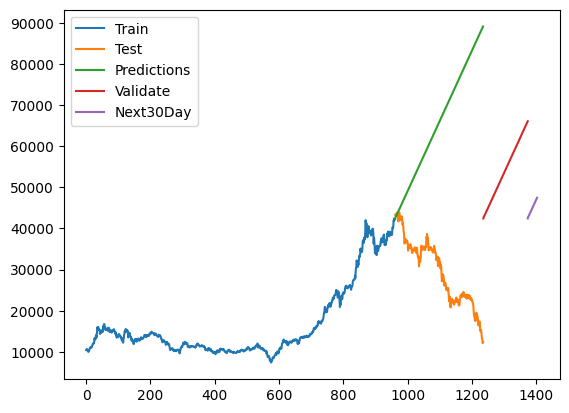

In [199]:

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()